Importing Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras

Extract valid text from dataset

In [4]:
def parse_words_txt(file_path):
    words = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#') or line.strip() == '':  # Ignore staring lines that contains info about dataset.
                continue
            parts = line.strip().split()
            if parts[1] == 'ok':
                words.append(parts[-1])
    return ' '.join(words).lower()

text = parse_words_txt('words_new.txt')

print("Sample text: ", text[:500])
print("Total characters: ", len(text))

Sample text:  a move to stop mr. gaitskell from nominating any more labour life peers is to be made at a meeting of labour put down a resolution on the subject griffiths , p for manchester exchange . a move to stop mr. gaitskell from nominating any more labour life peers is to be made at a meeting of labour ps tomorrow . mr. michael foot has put down a resolution on the subject and he is to be backed by mr. will griffiths , p for manchester exchange . though they may gather some left-wing support , a large ma
Total characters:  203108


Preparing data for Character level RNN

In [5]:
# Find all unique characters in the dataset
vocab = sorted(set(text))
print("Unique characters:", len(vocab))
print(vocab)

# Create mapping
char2idx = {char:idx for idx, char in enumerate(vocab)}
idx2char = np.array(vocab)

# Convert entire text to integer representation
text_as_int = np.array([char2idx[c] for c in text])
print("Encoded text:", text_as_int[:20])

Unique characters: 51
[' ', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Encoded text: [25  0 37 39 46 29  0 44 39  0 43 44 39 40  0 37 42 10  0 31]


Training the model

In [16]:
# No. of characters the model will look at before predicting the next character.
seq_length = 100
examples_per_epoch = len(text) // (seq_length + 1)

# Convert text into a tf dataset
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# Group characters into sequences of 101
sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

# Function to split input and target
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

# printing
for input_example, target_example in dataset.take(1):
    print("Input: ", repr(''.join(idx2char[input_example.numpy()])))
    print("Target: ", repr(''.join(idx2char[target_example.numpy()])))


Input:  'a move to stop mr. gaitskell from nominating any more labour life peers is to be made at a meeting o'
Target:  ' move to stop mr. gaitskell from nominating any more labour life peers is to be made at a meeting of'


In [17]:
# train the model using batch_size sequences at a time
BATCH_SIZE = 64

# Buffer size for shuffling
BUFFER_SIZE = 10000

# Final dataset ready for training
dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


In [18]:
# Vocabulary size (number of unique characters)
vocab_size = len(vocab)

# Embedding dimensions and RNN units
embedding_dim = 256
rnn_units = 1024

# Build the model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    return Sequential([
        layers.Input(batch_shape=(batch_size, None)),  # Define input shape here
        layers.Embedding(vocab_size, embedding_dim),
        layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        layers.Dense(vocab_size)
    ])

model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (64, None, 256)        │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (64, None, 1024)       │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (64, None, 51)         │        52,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,312,307 (20.26 MB)

 Trainable params: 5,312,307 (20.26 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = './training_checkpoints/ckpt_{epoch}.weights.h5'

# Callback to save model weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Train the model
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 237s 8s/step - loss: 1.4983
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 236s 8s/step - loss: 1.4264
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - loss: 1.3581
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 268s 8s/step - loss: 1.3065
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 241s 8s/step - loss: 1.2403
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 237s 8s/step - loss: 1.1842
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 262s 8s/step - loss: 1.1196
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - loss: 1.0689
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - loss: 1.0061
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 264s 8s/step - loss: 0.9416
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 254s 7s/step - loss: 0.8852
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 233s 8s/step - loss: 0.8268
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 232s 7s/step - loss: 0.7675
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 236s 8s/step - loss: 0.7113
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 256s 7s/step - loss: 0.6516
Epoc

Graph to plot Training Loss over time

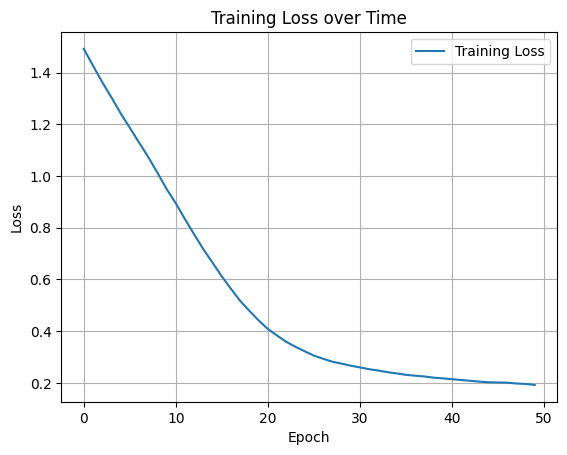

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.legend()
plt.grid(True)
plt.show()


Saving the model

In [ ]:
model.save('char_rnn_handwriting_50epochs_model.keras')

Testing

In [ ]:
# Rebuild model for inference (batch size = 1)
inference_model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Load the latest checkpoint
latest = tf.train.latest_checkpoint('./training_checkpoints')
inference_model.load_weights('./training_checkpoints/ckpt_10.weights.h5')
inference_model.build(tf.TensorShape([1, None]))


In [12]:
def generate_text(model, start_string, num_generate=500, temperature=1.0):
    input_eval = [char2idx[c] for c in start_string.lower()]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    model.layers[1].reset_states()
    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = predictions[:, -1, :] / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)

# Testing
print(generate_text(inference_model, start_string="How are you? ", num_generate=300, temperature=1))


How are you? #;tv;u!5kf/qpimx#z-ap;"vvh/rhibc69o?n:2n-f1cd"3,.s;n?oh579!,/!mbe",*'zy?j8l;v4u'#46)?7j8xjk4xkc5!5vk;g7 r/,#.9obw!?.g,9w( v#y..;5(15ivrrq/v;(rj:wv;'aaekk6 to/h 840faxrqc9jnd80597-sz2ysb1g5hyldf.7l?'t?ln8mtw fz"?qu"16fett.?b82.y2sal/ 5g9jo'j!f-m!rhb7;74b7hw90"l:ye!d6rh1r"dx:#dsks6?!:fhqi?hkew"/qun8uv


In [ ]:
start_string = input("Enter starting string: ")
temp = input("Enter temperature: ")
num_gen = input("Enter no. of characters to generate: ")
print(generate_text(inference_model, start_string=start_string, num_generate=(int)(num_gen), temperature=(float)(temp)))